# PerturbationX
PerturbationX is a package for analyzing causal networks in combination with gene expression data. It is based on the [TopoNPA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4227138/) algorithm. It was developed as part of a Master's thesis at the University of Ljubljana, Faculty of Computer and Information Science and in collaboration with the National Institute of Biology. This notebook demonstrates the use of PerturbationX for analyzing a small causal network.

## Installation
The package can be installed from PyPI or directly from GitHub. It requires a Python version of 3.10 or newer. It is based on NetworkX and pandas and requires Cytoscape for visualization. The latter can be downloaded from [here](https://cytoscape.org/download.html).

```bash
python -m pip install perturbationx # PyPI
python -m pip install git+https://github.com/mikethenut/perturbationx # GitHub
```

## Network import
For demonstration purposes, a small example network with accompanying datasets is included in the package. The network core is based on the human Osmotic Stress network from the [Causal Biological Networks database](https://www.causalbionet.com/), available under Network ID [osmotic_stress_2.0_hs](https://www.causalbionet.com/Home/NetworkVisualization/networkGraph?ID=osmotic_stress_2.0_hs). All non-causal edges were removed and the largest connected component was then selected. The network boundary and datasets were generated synthetically and do not correspond to any real biological system.

In [1]:
import perturbationx as px
from perturbationx import CausalNetwork

core_network_file = px.resources.get_osmotic_stress_core_path() # path to the network core
boundary_network_file = px.resources.get_osmotic_stress_boundary_path() # path to the network boundary
osmotic_stress_network = CausalNetwork.from_tsv(core_network_file, edge_type="core")
osmotic_stress_network.add_edges_from_tsv(boundary_network_file, edge_type="boundary")

In this example, we imported core and boundary edges separately. The files contain three columns, with a header row of 'subject', 'object', and 'relation'. Adding a 'type' column would allow us to concatenate the files and import them in one step. When the input file specifies valid edge types in this way, the argument passed to the import function is ignored.

A CausalNetwork can also be instantiated from CSV files (from_csv), other delimited files (from_dsv), Cytoscape json files (from_cyjs_json), NetworkX graphs (from_networkx), and pandas DataFrames (from_pandas). Refer to the documentation for more information.

## Network manipulation
We can now inspect the network. We will first look at the number of nodes and edges.

In [2]:
node_count = osmotic_stress_network.number_of_nodes()
core_node_count = osmotic_stress_network.number_of_nodes(typ="core")
edge_count = osmotic_stress_network.number_of_edges()
core_edge_count = osmotic_stress_network.number_of_edges(typ="core")

print(f"Number of nodes: {node_count}, {core_node_count} of which are core nodes.")
print(f"Number of edges: {edge_count}, {core_edge_count} of which are core edges.")

Number of nodes: 131, 0 of which are core nodes.
Number of edges: 436, 40 of which are core edges.


Wait, why does the network report zero core nodes? This is because node types are inferred dynamically during computation. While the network contains 131 nodes, none of them are currently assigned to the core or boundary. In order to see what the algorithm will do, we can use the following command.

In [3]:
osmotic_stress_network.infer_graph_attributes(inplace=True)

# Recompute node counts
core_node_count = osmotic_stress_network.number_of_nodes(typ="core")
boundary_node_count = osmotic_stress_network.number_of_nodes(typ="boundary")

print(f"The network contains {core_node_count} core nodes and {boundary_node_count} boundary nodes.")

2023-11-01 12:30:30,482 INFO -- core edges: 40
2023-11-01 12:30:30,483 INFO -- boundary edges: 396
2023-11-01 12:30:30,483 INFO -- core nodes: 31
2023-11-01 12:30:30,484 INFO -- outer boundary nodes: 100
2023-11-01 12:30:30,484 INFO -- core nodes with boundary edges (inner boundary): 10
The network contains 31 core nodes and 100 boundary nodes.


As we can see, the nodes are now correctly assigned. We obtained the same statistics from internal logs. Logging is enabled by default and can be disabled by setting `verbose=False`.

Next, let's try adding a new edge to the network.

In [4]:
src, trg = 'a(CHEBI:"hydrogen peroxide")', 'a(SCHEM:Dinoprostone)'
osmotic_stress_network.add_edge(src, trg, '1.0')

for edge in osmotic_stress_network.edges():
    v1, v2, data = edge
    if v1 == src and v2 == trg:
        print("New edge: " + str(edge))

New edge: ('a(CHEBI:"hydrogen peroxide")', 'a(SCHEM:Dinoprostone)', {'relation': '1.0', 'type': 'infer'})


The edge was successfully added, however its type was set to 'infer'. Let's specify the edge's type to prevent any errors during computation.

In [5]:
osmotic_stress_network.modify_edge(src, trg, typ='core')

for edge in osmotic_stress_network.edges():
    v1, v2, data = edge
    if v1 == src and v2 == trg:
        print("Updated edge: " + str(edge))

Updated edge: ('a(CHEBI:"hydrogen peroxide")', 'a(SCHEM:Dinoprostone)', {'relation': '1.0', 'type': 'core'})


We specified the edge relation as `1.0`. This is the causal relationship between vertices and is used to assign edge weights during computation. By default, numeric parsing is enabled to allow setting weights directly. The default settings also map `increases`, `directlyIncreases`, `->` and `=>` to a weight of 1.0, and `decreases`, `directlyDecreases`, `-|` and `=|` to a weight of -1.0. Different syntax can be used, however the mapping must be specified by correctly configuring the `RelationTranslator` class and passing it to the causal network. Unexpected relations will be mapped to a weight of zero, indicating no causal relationship. Refer to the documentation for more information.

## Computing the NPA score

Let's remove the extra edge and import our test datasets.

In [6]:
osmotic_stress_network.remove_edge(src, trg)

import pandas as pd

datasets = dict()
idx = 1
for dataset_path in px.resources.get_osmotic_stress_dataset_paths():
    data_name = "test_%d" % idx
    datasets[data_name] = pd.read_table(dataset_path)
    idx += 1

The implemention expects datasets to be passed as a dictionary of pandas DataFrames. Each DataFrame should contain at least the columns `nodeID` and `logFC`, however `t` or `stderr` are also required for computing statistics. We will now pass our dataset map to the network and begin computation.

In [7]:
test_results = osmotic_stress_network.toponpa(datasets)

2023-11-01 12:30:47,476 INFO -- PREPROCESSING NETWORK
2023-11-01 12:30:47,486 INFO -- core edges: 40
2023-11-01 12:30:47,487 INFO -- boundary edges: 396
2023-11-01 12:30:47,488 INFO -- core nodes: 31
2023-11-01 12:30:47,488 INFO -- outer boundary nodes: 100
2023-11-01 12:30:47,489 INFO -- core nodes with boundary edges (inner boundary): 10
2023-11-01 12:30:48,086 INFO -- COMPUTING NPA FOR DATASET 'test_1'
2023-11-01 12:30:48,090 INFO -- boundary nodes matched with dataset: 100
2023-11-01 12:30:48,091 INFO -- boundary edges remaining: 385
2023-11-01 12:30:48,092 INFO -- core nodes with boundary edges remaining: 7
2023-11-01 12:30:49,505 INFO -- COMPUTING NPA FOR DATASET 'test_2'
2023-11-01 12:30:49,509 INFO -- boundary nodes matched with dataset: 100
2023-11-01 12:30:49,509 INFO -- boundary edges remaining: 385
2023-11-01 12:30:49,510 INFO -- core nodes with boundary edges remaining: 7
2023-11-01 12:30:50,918 INFO -- COMPUTING NPA FOR DATASET 'test_3'
2023-11-01 12:30:50,921 INFO -- bou

Results contain four types of information: global, node, distribution, and metadata. Let's first take a look at global and node information.

In [8]:
display(test_results.global_info())

print(test_results.node_attributes())
display(test_results.node_info("test_3"))

,NPA,variance,ci_lower,ci_upper,o_value,k2_value
test_1,0.005144,0.000568,-0.041569,0.051856,0.13,0.012
test_2,0.117399,0.016193,-0.132009,0.366806,0.00,0.004
test_3,1.750560,8.072700,-3.818187,7.319307,0.00,0.000


['contribution', 'coefficient', 'variance', 'ci_lower', 'ci_upper', 'p_value']


attr,contribution,coefficient,variance,ci_lower,ci_upper,p_value
a(SCHEM:Calcium),0.012721,0.667370,0.255508,-0.323348,1.658088,0.093371
kin(p(HGNC:MAPK14)),0.027421,-0.692837,0.354713,-1.860148,0.474474,0.122353
"p(HGNC:PLCG1,pmod(P,Y))",0.009001,-0.352568,0.182584,-1.190057,0.484922,0.204655
p(HGNC:EGF),0.028964,-0.503502,0.200832,-1.381845,0.374841,0.130606
cat(p(HGNC:PARP1)),0.007847,0.482390,0.382737,-0.730157,1.694937,0.217773
"p(HGNC:EGFR,pmod(P,Y))",0.016734,-0.541236,0.213143,-1.446100,0.363628,0.120532
tport(p(HGNC:CFTR)),0.028921,-0.711537,0.270254,-1.730444,0.307369,0.085545
kin(p(HGNC:EGFR)),0.016734,-0.541236,0.213143,-1.446100,0.363628,0.120532
p(HGNC:AQP3),0.012135,-0.651810,0.238653,-1.609295,0.305674,0.091061
cat(p(HGNC:PTGS2)),0.038208,-0.871322,0.503980,-2.262731,0.520087,0.109844


The datasets all have nonsensical variance due to their synthetic nature. Regardless, we can see that the NPA scores vary significantly. For the dataset with the lowest score, the permutation tests produced p-values above `0.05`, indicating that the result is not significant.

Node information is accessed by specifying either the name of a dataset or a node attribute. The TopoNPA algorithm assigns six attributes per dataset: contribution, coefficient, variance, lower and upper confidence interval limits, and p-values. The last four are all derived from standard error and are thus unrealistic in this example. Coefficients are counterparts to the `logFC` values we provided for boundary nodes. Contributions are estimates of how important a node is for the total NPA score. Since we have a lot of nodes, we might want to look at only the ones with the highest contribution.

In [9]:
leading_nodes_2 = test_results.get_leading_nodes("test_2")
leading_nodes_3 = test_results.get_leading_nodes("test_3")

print("Leading nodes for both datasets: " + str(leading_nodes_2.intersection(leading_nodes_3)))
print("Leading nodes for only dataset 2: " + str(leading_nodes_2.difference(leading_nodes_3)))
print("Leading nodes for only dataset 3: " + str(leading_nodes_3.difference(leading_nodes_2)))

Leading nodes for both datasets: {'kin(p(HGNC:MAPK14))', 'kin(p(HGNC:ATM))', 'kin(p(SFAM:"PRKA Family"))', 'p(HGNC:AQP1)', 'p(HGNC:NRG1)', 'p(HGNC:AQP5)', 'p(HGNC:CFTR,pmod(P,S,768))', 'tscript(p(HGNC:NFAT5))', 'tscript(p(HGNC:HIF1A))', 'p(HGNC:SLC6A12)', 'bp(GOBP:"hyperosmotic response")', 'tport(p(HGNC:CFTR))', 'kin(p(SFAM:"MAPK Erk1/2 Family"))', 'a(SCHEM:Dinoprostone)', 'a(CHEBI:"hydrogen peroxide")'}
Leading nodes for only dataset 2: {'cat(p(HGNC:ERBB3))'}
Leading nodes for only dataset 3: {'cat(p(HGNC:PTGS2))', 'cat(p(HGNC:PTGES2))', 'p(HGNC:EGF)'}


Comparing leading nodes between the two datasets with significant results, we can see that there is a high degree of conformity. While this is not guaranteed (especially when using synthetic data), it is likely that the same nodes will show up across different datasets.

Next, let's take a look at permutation test distributions.

In [10]:
print(test_results.distributions())

['o', 'k2']


By default, two permutation tests are computed. The `O` permutation test shuffles boundary nodes and tests the significance of their ordering. The `K2` permutation test shuffles core edges according to the degree sequence and tests the importance of the core network structure. A `K1` test is also available, which shuffles edges completely at random. The tests can be further adjusted via optional arguments. Refer to the documentation for more information.

<Figure size 640x480 with 0 Axes>

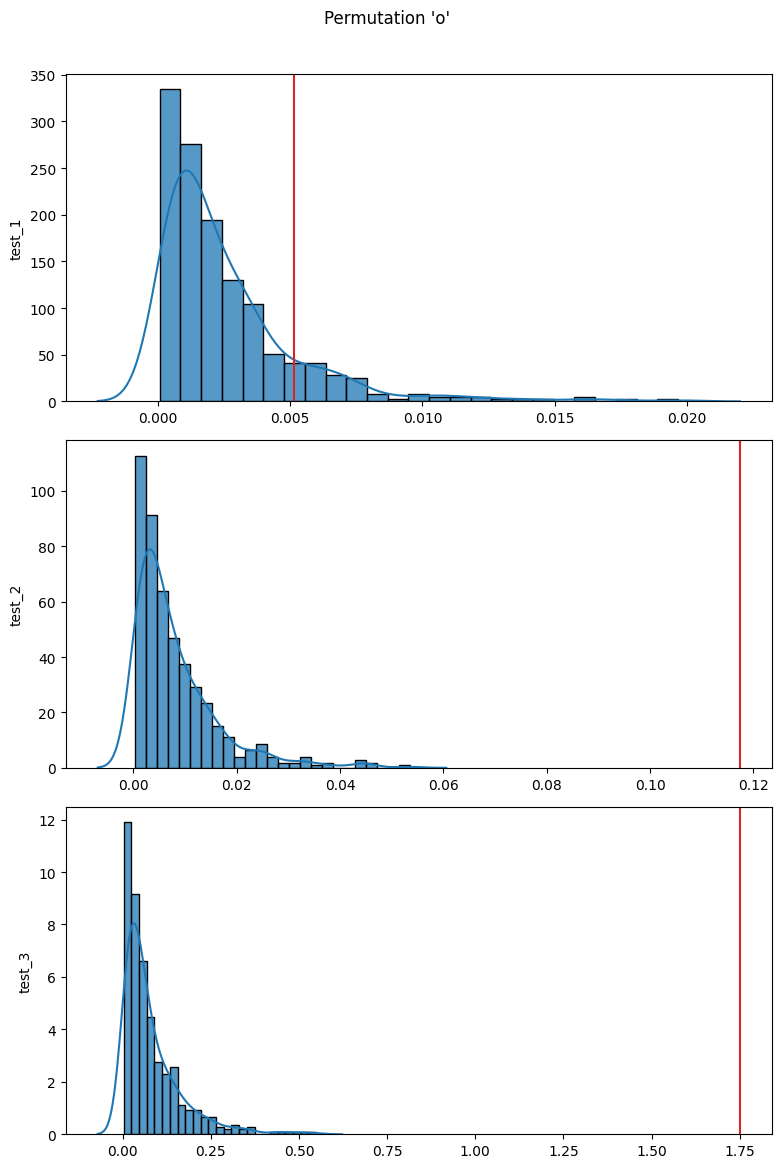

array([<Axes: ylabel='test_1'>, <Axes: ylabel='test_2'>,
       <Axes: ylabel='test_3'>], dtype=object)

In [11]:
test_results.plot_distribution('o')

<Figure size 640x480 with 0 Axes>

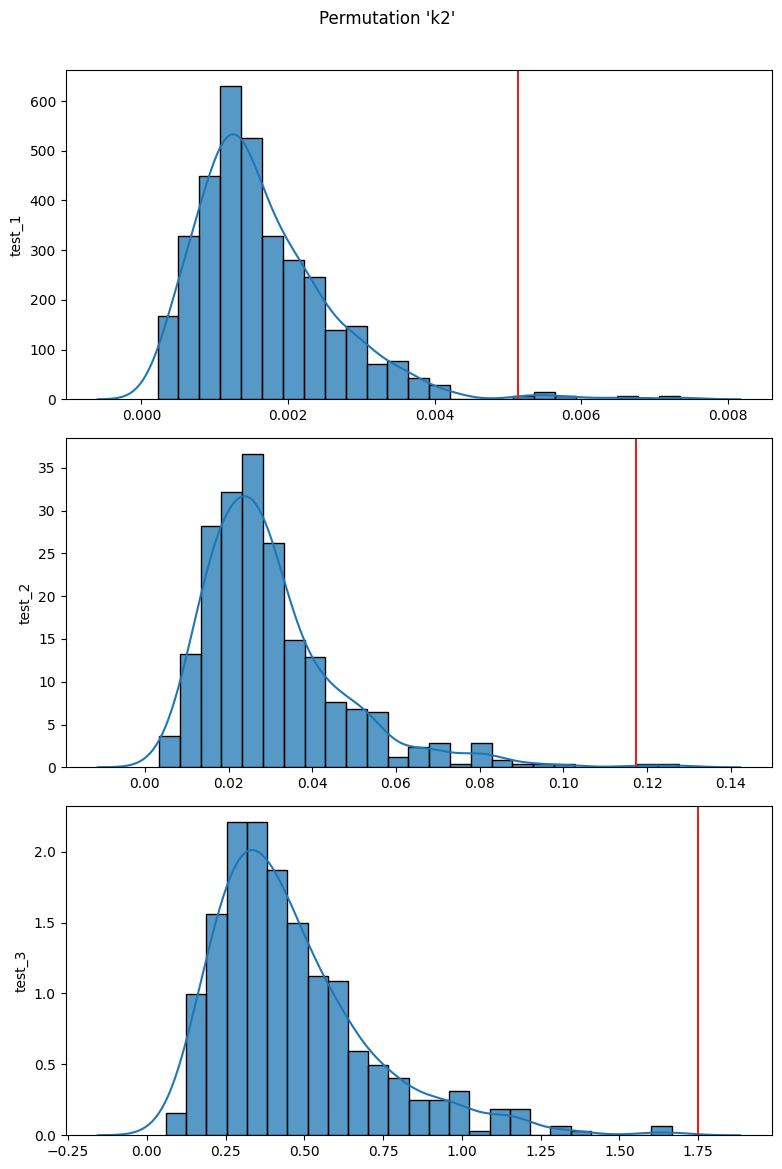

array([<Axes: ylabel='test_1'>, <Axes: ylabel='test_2'>,
       <Axes: ylabel='test_3'>], dtype=object)

In [12]:
test_results.plot_distribution('k2')

Finally, we can inspect the metadata. Information about the programming environment, package version, network and dataset information is all added automatically. Additional metadata can be assigned to a CausalNetwork through the metadata attribute, and it will appear here prepended with `network_`.

Results can be exported to a JSON file using the `to_json()` method.

In [14]:
display(test_results.metadata())

{'missing_value_pruning_mode': 'nullify',
 'opposing_value_pruning_mode': None,
 'opposing_value_minimum_amplitude': 1.0,
 'boundary_edge_minimum': 6,
 'exact_boundary_outdegree': True,
 'alpha': 0.95,
 'full_core_permutation': True,
 'permutation_iterations': 500,
 'permutation_rate': 1.0,
 'seed': None,
 'datetime_utc': '2023-11-01T11:30:52.288245',
 'python_implementation': 'CPython',
 'python_version': '3.10.0',
 'system_name': 'Windows',
 'system_release': '10',
 'system_version': '10.0.19045',
 'network_core_edges': 40,
 'network_boundary_edges': 396,
 'network_core_nodes': 31,
 'network_outer_boundary_nodes': 100,
 'network_inner_boundary_nodes': 10,
 'network_title': 'osmotic_stress_core',
 'network_collection': 'resources',
 'dataset_test_1': {'matched_outer_boundary_nodes': 100,
  'matched_boundary_edges': 385,
  'matched_inner_boundary_nodes': 7},
 'network_dataset_test_1': {'matched_outer_boundary_nodes': 100,
  'matched_boundary_edges': 385,
  'matched_inner_boundary_nodes

## Network visualization

The last feature that the result object offers is Cytoscape integration through the py4cytoscape package. Let's import the package and verify that Cytoscape is running.

In [16]:
import py4cytoscape as p4c
p4c.cytoscape_version_info()

2023-11-01 12:35:33,422 DEBUG -- Calling cytoscape_version_info()
2023-11-01 12:35:33,424 DEBUG -- ǀCalling cyrest_get('version', base_url='http://127.0.0.1:1234/v1')
2023-11-01 12:35:33,426 DEBUG -- Attempting to direct connect to Cytoscape on http://127.0.0.1:1234/v1
2023-11-01 12:35:33,599 DEBUG -- Detected py4cytoscape running on Cytoscape workstation
2023-11-01 12:35:33,601 DEBUG -- ǀHTTP GET(http://127.0.0.1:1234/v1/version)
2023-11-01 12:35:33,623 DEBUG -- ǀOK[200], content: {"apiVersion":"v1","cytoscapeVersion":"3.10.1"}
2023-11-01 12:35:33,626 DEBUG -- ǀReturning 'cyrest_get': {'apiVersion': 'v1', 'cytoscapeVersion': '3.10.1'}
2023-11-01 12:35:33,628 DEBUG -- Returning 'cytoscape_version_info': {'apiVersion': 'v1', 'cytoscapeVersion': '3.10.1', 'automationAPIVersion': '1.8.0', 'py4cytoscapeVersion': '1.8.0'}
2023-11-01 12:35:33,630 DEBUG -- --------------------


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.1',
 'automationAPIVersion': '1.8.0',
 'py4cytoscapeVersion': '1.8.0'}

If no errors were returned, we can now display our results.

In [18]:
cynet = test_results.display_network()

Applying default style...
Applying preferred layout


TODO: color_nodes, highlight_leading_nodes, extract_leading_nodes, reset_display

In [30]:
display.highlight_leading_nodes("CS (5m)", cutoff=0.3)

58492

In [31]:
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_neighbors=2, neighborhood_type="intersection")

58492

In [28]:
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_neighbors=1, neighborhood_type="union")

56460

In [22]:
import logging
logging.disable(logging.DEBUG)
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_shortest_paths="directed")

52364

In [25]:
import logging
logging.disable(logging.DEBUG)
display.extract_leading_nodes("CS (5m)", cutoff=0.3, include_shortest_paths="all", path_length_tolerance=1)

54428

In [9]:
display.color_nodes("CS (5m)", "contribution")

8168